In [1]:
!pip install ale-py

In [2]:
import gym
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import ale_py.roms as roms
print(roms.__all__)

['Tetris']


In [4]:
from ale_py.roms import Tetris

## 查看环境

In [5]:
env = gym.make('ALE/Tetris')

/Users/tinyzqh/miniforge3/lib/python3.9/site-packages/gym/envs/registration.py:511: UserWarning: WARN: Using the latest versioned environment `ALE/Tetris-v5` instead of the unversioned environment `ALE/Tetris`
  logger.warn(
A.L.E: Arcade Learning Environment (version 0.7.4+069f8bd)
[Powered by Stella]


In [6]:
print(env.observation_space)

Box(0, 255, (210, 160, 3), uint8)


In [7]:
print(env.action_space)

Discrete(5)


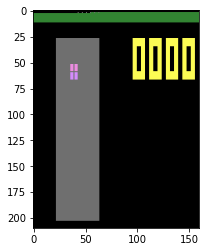

In [8]:
plt.imshow(env.render("rgb_array"))
plt.show()

## 预处理输入图像

In [9]:
from skimage.transform import resize
from skimage.color import rgb2gray, gray2rgb
from skimage import img_as_float

from gym.core import ObservationWrapper
from gym.spaces import Box

class PreprocessAtari(ObservationWrapper):
    def __init__(self, env):
        """
        将原始图像转换成指定大小的灰度图
        """
        super(PreprocessAtari, self).__init__(env)
        
        self.img_size = (64, 64)
        self.observation_space = Box(0.0, 1.0, (self.img_size[0], self.img_size[1], 1))

    def observation(self, img):
        
        img = img[20:-5, 5:-70]  # 裁剪图像。
        img = resize(img, self.img_size)  # 重定义大小。
        img = rgb2gray(img)  # 转换成灰度图。
        img = np.expand_dims(img, -1)  
        img = img_as_float(img)
        img = np.float32(img)
        
        return img

observation shape (64, 64, 1)
n_actions shape 5
Formal tests seem fine. Here's an example of what you'll get.


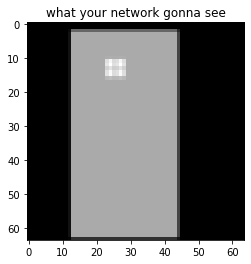

In [10]:
env = PreprocessAtari(env)

observation_shape = env.observation_space.shape
n_actions = env.action_space.n

print("observation shape {}".format(observation_shape))
print("n_actions shape {}".format(n_actions))

obs = env.reset()

#test observation
assert obs.ndim == 3, "observation must be [batch, time, channels] even if there's just one channel"
assert obs.shape == observation_shape
assert obs.dtype == 'float32'
assert len(np.unique(obs)) > 2, "your image must not be binary"
assert 0 <= np.min(obs) and np.max(obs) <=1, "convert image pixels to (0,1) range"

print("Formal tests seem fine. Here's an example of what you'll get.")

plt.title("what your network gonna see")
plt.imshow(obs[:,:,0],interpolation='none',cmap='gray')

## 图像Buffer

由于每次`step`都是处理一张图像，为了看到图像之间的前后关系，这里采用一个图像`buffer`存储多张图像。

In [11]:
from gym.core import Wrapper

class FrameBuffer(Wrapper):
    def __init__(self, env, n_frames=4):
        """将图像的通道数乘以n_frames"""
        super(FrameBuffer, self).__init__(env)
        height, width, n_channels = env.observation_space.shape
        obs_shape = [n_channels * n_frames, height, width]
        
        self.observation_space = Box(0.0, 1.0, obs_shape)
        self.framebuffer = np.zeros(obs_shape, 'float32')
        
    def reset(self):
        """resets breakout, returns initial frames"""
        self.framebuffer = np.zeros_like(self.framebuffer)
        self.update_buffer(self.env.reset())
        return self.framebuffer
    
    def step(self, action):
        """plays breakout for 1 step, returns frame buffer"""
        new_img, reward, done, info = self.env.step(action)
        self.update_buffer(new_img)
        return self.framebuffer, reward, done, info
    
    def update_buffer(self, img):
        
        offset = self.env.observation_space.shape[-1]
        axis = 0
        cropped_framebuffer = self.framebuffer[:-offset]
        img = img.reshape(-1, self.env.observation_space.shape[0], self.env.observation_space.shape[1])
        
        self.framebuffer = np.concatenate([img, cropped_framebuffer], axis = axis)

## 构建环境函数

基于上面的输入预处理和图像`Buffer`构建封装之后的环境:

In [12]:
def make_env():
    env = gym.make('ALE/Tetris')
    env = PreprocessAtari(env)
    print(env.observation_space.shape)
    env = FrameBuffer(env, n_frames=4)
    return env

In [13]:
env = make_env()
env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape
print("n_actions : {}".format(n_actions))
print("obs shape : {}".format(state_dim))

(64, 64, 1)
n_actions : 5
obs shape : (4, 64, 64)


/Users/tinyzqh/miniforge3/lib/python3.9/site-packages/gym/envs/registration.py:511: UserWarning: WARN: Using the latest versioned environment `ALE/Tetris-v5` instead of the unversioned environment `ALE/Tetris`
  logger.warn(


(4, 64, 64)


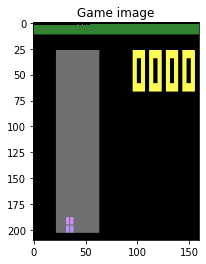

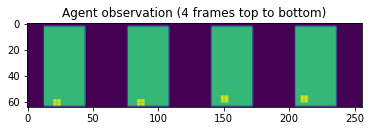

In [14]:
for _ in range(50):
    obs, _, _, _ = env.step(env.action_space.sample())

print(obs.reshape([-1, state_dim[1], state_dim[2]]).shape)
plt.title("Game image")
plt.imshow(env.render("rgb_array"))
plt.show()
plt.title("Agent observation (4 frames top to bottom)")
plt.imshow(obs.transpose([1, 0, 2]).reshape([state_dim[1] , -1]))

## 构建智能体

In [15]:
import torch.nn as nn

class DQNAgent(nn.Module):
    def __init__(self, state_shape, n_actions, epsilon=0):
        super(DQNAgent, self).__init__()
        
        self.epsilon = epsilon
        self.n_actions = n_actions
        img_c, img_w, img_h = state_shape
        
        self.net = nn.Sequential(
            nn.Conv2d(4, 16, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(1*64*7*7, 256),
            nn.ReLU(),
            nn.Linear(256, self.n_actions)
        )
            

    def forward(self, state_t):
        """
        接收观测输入，返回q_values。
        参数: state_t是一个batch的4帧图片，shape = [batch_size, 4, h, w]
        """
        q_values = self.net(state_t)
        assert isinstance(q_values, torch.Tensor) and q_values.requires_grad, "qvalues must be a torch variable with grad"
        assert len(q_values.shape) == 2 and q_values.shape[0] == state_t.shape[0] and q_values.shape[1] == n_actions
        return q_values

    def get_qvalues(self, states):
        """
        与前向传播类似，但是返回numpy数据类型，不返回变量。
        """
        states = torch.FloatTensor(np.asarray(states))
        q_values = self.forward(states)
        
        return q_values.data.cpu().numpy()
    
    def sample_actions(self, qvalues):
        """
        基于epsilon-greedy exploration策略选择动作
        """
        epsilon = self.epsilon
        batch_size, n_actions = qvalues.shape
        
        random_actions = np.random.choice(n_actions, size=batch_size)
        best_actions = qvalues.argmax(axis=-1)
        
        should_explore = np.random.choice([0, 1], batch_size, p = [epsilon, 1 - epsilon])
        return np.where(should_explore, random_actions, best_actions)

In [16]:
agent = DQNAgent(state_dim, n_actions, epsilon=0.5)

### 测试智能体网络

In [17]:
import torch
X = torch.randn(size=(1, 4, 64, 64), dtype=torch.float32)
for layer in agent.net:
    X = layer(X)
    print(layer.__class__.__name__, "Out Put Shape: ", X.shape)

Conv2d Out Put Shape:  torch.Size([1, 16, 31, 31])
ReLU Out Put Shape:  torch.Size([1, 16, 31, 31])
Conv2d Out Put Shape:  torch.Size([1, 32, 15, 15])
ReLU Out Put Shape:  torch.Size([1, 32, 15, 15])
Conv2d Out Put Shape:  torch.Size([1, 64, 7, 7])
ReLU Out Put Shape:  torch.Size([1, 64, 7, 7])
Flatten Out Put Shape:  torch.Size([1, 3136])
Linear Out Put Shape:  torch.Size([1, 256])
ReLU Out Put Shape:  torch.Size([1, 256])
Linear Out Put Shape:  torch.Size([1, 5])


### 测试网络前向传播

In [18]:
X = torch.randn(size=(1, 4, 64, 64), dtype=torch.float32)
print(agent(X))

tensor([[ 0.0522,  0.0381,  0.0578,  0.0044, -0.0507]],
       grad_fn=<AddmmBackward>)


In [19]:
def evaluate(env, agent, n_games=1, greedy=False, t_max=10000):
    rewards = []
    for _ in range(n_games):
        obs = env.reset()
        reward = 0
        for _ in range(t_max):
            obs = np.expand_dims(obs, axis=0)  # 扩展一个batch_size的维度。
            q_values = agent.get_qvalues(obs)
            action = q_values.argmax(axis=-1)[0] if greedy else agent.sample_actions(q_values)[0]
            next_obs, reward, done, info = env.step(action)
            reward += 0
            
            if done: break
            obs = next_obs
        rewards.append(reward)
    return np.mean(rewards)

In [20]:
evaluate(env, agent, n_games=1)

0.0

## 经验回放

In [21]:
import random
import numpy as np

class ReplayBuffer(object):
    def __init__(self, size):
        """
        创建一个Buffer。
        """
        self.buffer = []
        self._maxsize = size
        self.cnt = 0
        
    def __len__(self):
        """
        返回buffer的长度。
        """
        return len(self.buffer)

    def push(self, state, action, reward, next_state, done):
        """
        
        """
        data = (state, action, reward, next_state, done)

        if len(self.buffer) == self._maxsize:
            self.buffer = self.buffer[1:]
            
        self.buffer.append(data)
        
    def sample(self, batch_size):
        
        #<randomly generate batch_size integers to be used as indexes of samples>
        buffer_size = len(self.buffer)
        idxes = np.random.randint(buffer_size, size = batch_size)
        
        state, action, reward, next_state, done = zip(*[self.buffer[idx] for idx in idxes])
        
        return np.array(state), np.array(action), np.array(reward), np.array(next_state), np.array(done)

In [22]:

exp_replay = ReplayBuffer(10)

for _ in range(30):
    exp_replay.push(env.reset(), env.action_space.sample(), 1.0, env.reset(), done=False)

obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(5)

assert len(exp_replay) == 10, "experience replay size should be 10 because that's what maximum capacity is"

In [23]:
def play_and_record(agent, env, exp_replay, n_steps=1):
    """
    Play the game for exactly n steps, record every (s,a,r,s', done) to replay buffer. 
    Whenever game ends, add record with done=True and reset the game.
    :returns: return sum of rewards over time
    
    Note: please do not env.reset() unless env is done.
    It is guaranteed that env has done=False when passed to this function.
    """
    # State at the beginning of rollout
    s = env.framebuffer
    
    # Play the game for n_steps as per instructions above
    # <YOUR CODE>
    
    total_reward = 0.0
    
    for _ in range(n_steps):
        qvalues = agent.get_qvalues([s])
        action = agent.sample_actions(qvalues)[0]
        #print(action)
        next_s, r, done, _ = env.step(action)
        #print(done)
        
        exp_replay.push(s, action, r, next_s, done)
        total_reward +=r
        s = next_s
        
        if done: 
            s = env.reset()
    
    return total_reward

In [24]:
# testing your code. This may take a minute...
exp_replay = ReplayBuffer(20000)

play_and_record(agent, env, exp_replay, n_steps=10000)

# if you're using your own experience replay buffer, some of those tests may need correction. 
# just make sure you know what your code does
assert len(exp_replay) == 10000, "play_and_record should have added exactly 10000 steps, "\
                                 "but instead added %i" % len(exp_replay)
is_dones = list(zip(*exp_replay.buffer))[-1]

assert 0 < np.mean(is_dones) < 0.1, "Please make sure you restart the game whenever it is 'done' and record the is_done correctly into the buffer."\
                                    "Got %f is_done rate over %i steps. [If you think it's your tough luck, just re-run the test]"%(np.mean(is_dones), len(exp_replay))
    
for _ in range(100):
    obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(10)
    assert obs_batch.shape == next_obs_batch.shape == (10,) + state_dim
    assert act_batch.shape == (10,), "actions batch should have shape (10,) but is instead %s"%str(act_batch.shape)
    assert reward_batch.shape == (10,), "rewards batch should have shape (10,) but is instead %s"%str(reward_batch.shape)
    assert is_done_batch.shape == (10,), "is_done batch should have shape (10,) but is instead %s"%str(is_done_batch.shape)
    assert [int(i) in (0,1) for i in is_dones], "is_done should be strictly True or False"
    assert [0 <= a <= n_actions for a in act_batch], "actions should be within [0, n_actions]"
    
print("Well done!")

Well done!


## 目标网络

In [25]:
target_network = DQNAgent(state_dim, n_actions)

In [26]:
# This is how you can load weights from agent into target network
target_network.load_state_dict(agent.state_dict())

<All keys matched successfully>

### Learning with... Q-learning

Here we write a function similar to `agent.update` from tabular q-learning.

Compute Q-learning TD error:

$$ L = { 1 \over N} \sum_i [ Q_{\theta}(s,a) - Q_{reference}(s,a) ] ^2 $$

With Q-reference defined as

$$ Q_{reference}(s,a) = r(s,a) + \gamma \cdot max_{a'} Q_{target}(s', a') $$

Where
* $Q_{target}(s',a')$ denotes q-value of next state and next action predicted by __target_network__
* $s, a, r, s'$ are current state, action, reward and next state respectively
* $\gamma$ is a discount factor defined two cells above.


__Note 1:__ there's an example input below. Feel free to experiment with it before you write the function.
__Note 2:__ compute_td_loss is a source of 99% of bugs in this homework. If reward doesn't improve, it often helps to go through it line by line [with a rubber duck](https://rubberduckdebugging.com/).

In [57]:
def compute_td_loss(states, actions, rewards, next_states, is_done, gamma = 0.99, check_shapes = False):
    """ Compute td loss using torch operations only. Use the formula above. """
    states = torch.FloatTensor(states)    # shape: [batch_size, c, h, w]
    actions = torch.LongTensor(actions)    # shape: [batch_size]
    rewards = torch.FloatTensor(rewards)  # shape: [batch_size]
    next_states = torch.FloatTensor(next_states) # shape: [batch_size, c, h, w]
    is_done = torch.FloatTensor(is_done.astype('float32'))  # shape: [batch_size]
    is_not_done = 1 - is_done
    
    #get q-values for all actions in current states
    predicted_qvalues = agent(states)
    
    # compute q-values for all actions in next states
    predicted_next_qvalues = target_network(next_states)
    
    #select q-values for chosen actions
    predicted_qvalues_for_actions = predicted_qvalues[range(len(actions)), actions]
    

    # compute V*(next_states) using predicted next q-values
    next_state_values = torch.max(predicted_next_qvalues, dim=1)[0]
    
    assert next_state_values.dim() == 1 and next_state_values.shape[0] == states.shape[0], "must predict one value per state"

    # compute "target q-values" for loss - it's what's inside square parentheses in the above formula.
    # at the last state use the simplified formula: Q(s,a) = r(s,a) since s' doesn't exist
    # you can multiply next state values by is_not_done to achieve this.
    target_qvalues_for_actions = rewards + gamma * next_state_values * is_not_done
    
    #mean squared error loss to minimize
    loss = torch.mean((predicted_qvalues_for_actions - target_qvalues_for_actions.detach()) ** 2 )
    
    if check_shapes:
        assert predicted_next_qvalues.data.dim() == 2, "make sure you predicted q-values for all actions in next state"
        assert next_state_values.data.dim() == 1, "make sure you computed V(s') as maximum over just the actions axis and not all axes"
        assert target_qvalues_for_actions.data.dim() == 1, "there's something wrong with target q-values, they must be a vector"
    
    return loss

In [59]:
# sanity checks
obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(10)

loss = compute_td_loss(obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch, gamma=0.99,
                       check_shapes=True)
loss.backward()

assert isinstance(loss, torch.Tensor) and isinstance(loss.item(), float), "you must return scalar loss - mean over batch"
assert np.any(next(agent.parameters()).grad.data.numpy() != 0), "loss must be differentiable w.r.t. network weights"

## 主循环

In [61]:
from tqdm import trange
from IPython.display import clear_output
import matplotlib.pyplot as plt

%matplotlib inline

mean_rw_history = []
td_loss_history = []

In [62]:
exp_replay = ReplayBuffer(10**5)
play_and_record(agent, env, exp_replay, n_steps=10000);

In [63]:
import torch.optim as optim
opt = optim.Adam(agent.parameters())
# opt = < your favorite optimizer. Default to adam if you don't have one >

buffer size = 68040, epsilon = 0.43876


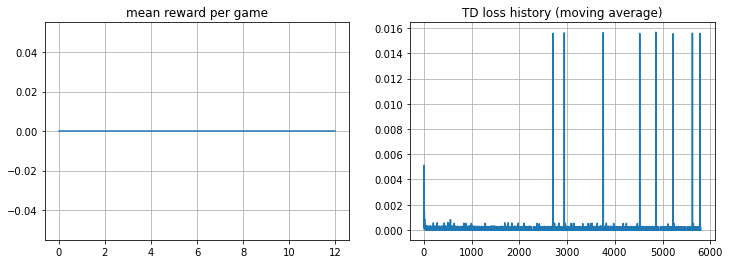

  6%|████▉                                                                              | 5898/100000 [13:02<3:01:51,  8.62it/s]

In [ ]:
for i in trange(10**5):
    
    # play
    play_and_record(agent, env, exp_replay, 10)
    
    # train
    obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(batch_size=64)
    # < sample data from experience replay>
    
    loss = compute_td_loss(obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch)
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    # < minimize loss by gradient descent >
    
    td_loss_history.append(loss.item())
    
    # adjust agent parameters
    if i % 500 == 0:
        agent.epsilon = max(agent.epsilon * 0.99, 0.01)
        mean_rw_history.append(evaluate(make_env(), agent, n_games=3))
        
        #Load agent weights into target_network
        # <YOUR CODE>
        target_network.load_state_dict(agent.state_dict())
        
    
    if i % 100 == 0:
        clear_output(True)
        print("buffer size = %i, epsilon = %.5f" % (len(exp_replay), agent.epsilon))
        plt.figure(figsize=[12, 4])        
        plt.subplot(1,2,1)
        plt.title("mean reward per game")
        plt.plot(mean_rw_history)
        plt.grid()

        assert not np.isnan(td_loss_history[-1])
        plt.subplot(1,2,2)
        plt.title("TD loss history (moving average)")
        plt.plot(td_loss_history)
        plt.grid()
        plt.show()

In [ ]:
assert np.mean(mean_rw_history[-10:]) > 10.
print("That's good enough for tutorial.")